<a href="https://colab.research.google.com/github/Devansharma/Time_Series_Analysis/blob/master/Anomaly_Detection_using_FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [6]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [9]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [10]:
df = df.set_index('timestamp').resample("H").mean()

In [12]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                     dict(count=1, label='1y', step='year', stepmode='backward'),
                     dict(count=2, label='3y', step='year', stepmode='backward'),
                     dict(count=3, label='5y', step='year', stepmode='backward'),
                     dict(step='all')
        ])
    )
)
fig.show()

In [13]:
from fbprophet import Prophet

In [14]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 
                                                           'value':'y'}, 
                                                          axis='columns')

In [15]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [16]:
train = taxi_df[(taxi_df['ds']>='2014-07-01')&(taxi_df['ds']<='2015-01-27')]
test = taxi_df[(taxi_df['ds']>'2015-01-27')]

In [17]:
print(train.shape)
print(test.shape)

(5041, 2)
(119, 2)


In [18]:
model = Prophet(changepoint_range=0.95)

In [19]:
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [20]:
future = model.make_future_dataframe(periods=119, freq='H')

In [21]:
future.tail()

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


In [23]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23799.138475,18953.165257,28469.520099
5156,2015-01-31 20:00:00,24363.213509,19706.024400,29066.231632
5157,2015-01-31 21:00:00,23239.944146,18777.845765,27670.051184
5158,2015-01-31 22:00:00,21048.028181,16255.880992,25825.365141
5159,2015-01-31 23:00:00,18520.934054,13682.021048,23217.127232


In [24]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower', 'yhat_upper']]],
                    axis=1)

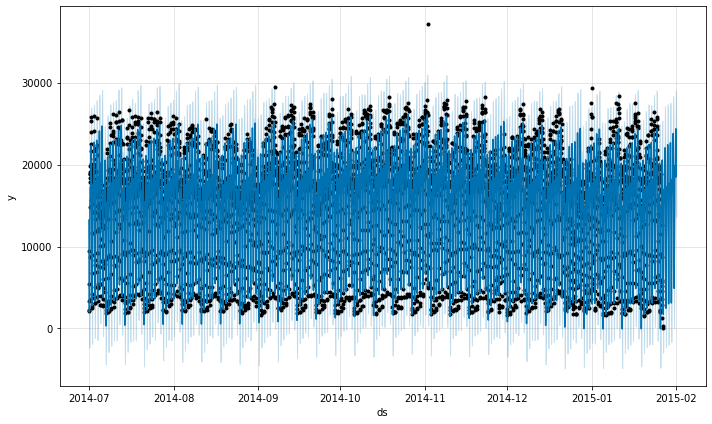

In [25]:
fig1 = model.plot(forecast)

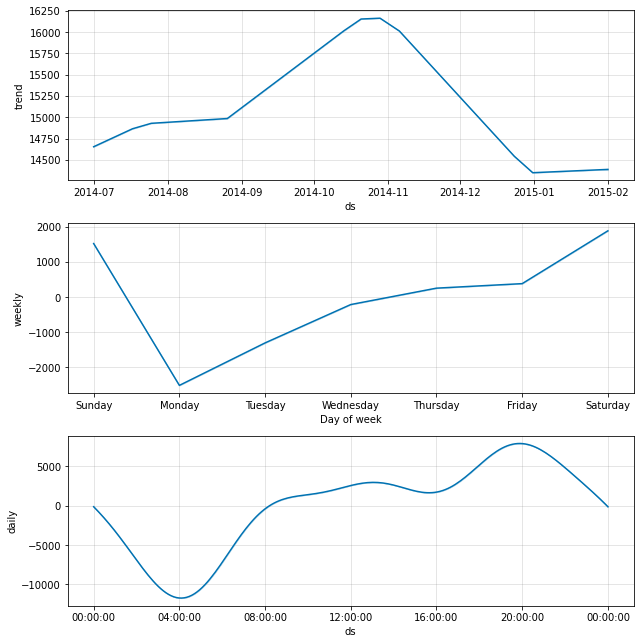

In [27]:
comp = model.plot_components(forecast)

In [28]:
results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8497.916115,17932.203299
2014-07-01 01:00:00,5433.0,10220.194393,5261.400204,14692.970273
2014-07-01 02:00:00,3346.5,6656.895387,1601.595897,11320.226122
2014-07-01 03:00:00,2216.5,3435.918478,-1201.665186,8449.636716
2014-07-01 04:00:00,2189.5,2005.330278,-2327.320196,6790.328654


In [29]:
results['error'] = results['y'] - results['yhat'] 

In [33]:
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']

In [34]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8497.916115,17932.203299,-3742.839092,9434.287184
2014-07-01 01:00:00,5433.0,10220.194393,5261.400204,14692.970273,-4787.194393,9431.570068
2014-07-01 02:00:00,3346.5,6656.895387,1601.595897,11320.226122,-3310.395387,9718.630225
2014-07-01 03:00:00,2216.5,3435.918478,-1201.665186,8449.636716,-1219.418478,9651.301902
2014-07-01 04:00:00,2189.5,2005.330278,-2327.320196,6790.328654,184.169722,9117.648850


In [35]:
results[results['error'].abs()>1.5*results['uncertainity']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-11-02 01:00:00,37204.5,14215.495541,9842.912831,18942.177777,22989.004459,9099.264946
2015-01-01 01:00:00,29292.0,11402.685988,6510.376958,16375.264336,17889.314012,9864.887378
2015-01-01 02:00:00,25753.5,7767.243272,3397.420279,12599.717962,17986.256728,9202.297683
2015-01-01 03:00:00,22067.0,4476.113854,-237.663856,9449.869112,17590.886146,9687.532969
2015-01-26 19:00:00,4565.5,19788.034941,15349.410125,24434.452965,-15222.534941,9085.042840
2015-01-26 20:00:00,3630.5,20563.358247,15700.946442,25379.495856,-16932.858247,9678.549413
2015-01-26 21:00:00,2907.0,19664.535017,14958.299792,24800.671109,-16757.535017,9842.371317
2015-01-26 22:00:00,1324.5,17708.853168,12715.351416,22436.718408,-16384.353168,9721.366992
2015-01-26 23:00:00,243.0,15428.310469,10924.482781,20320.421883,-15185.310469,9395.939103


In [36]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])>1.5*x['uncertainity']) else 'No',axis=1)

In [37]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8497.916115,17932.203299,-3742.839092,9434.287184,No
2014-07-01 01:00:00,5433.0,10220.194393,5261.400204,14692.970273,-4787.194393,9431.570068,No
2014-07-01 02:00:00,3346.5,6656.895387,1601.595897,11320.226122,-3310.395387,9718.630225,No
2014-07-01 03:00:00,2216.5,3435.918478,-1201.665186,8449.636716,-1219.418478,9651.301902,No
2014-07-01 04:00:00,2189.5,2005.330278,-2327.320196,6790.328654,184.169722,9117.648850,No


In [38]:
fig = px.scatter(results.reset_index(), x='ds', y='y', 
                 color='anomaly',title='NYC Taxi Demand')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                     dict(count=1, label='1y', step='year', stepmode='backward'),
                     dict(count=2, label='3y', step='year', stepmode='backward'),
                     dict(count=3, label='5y', step='year', stepmode='backward'),
                     dict(step='all')
        ])
    )
)
fig.show()

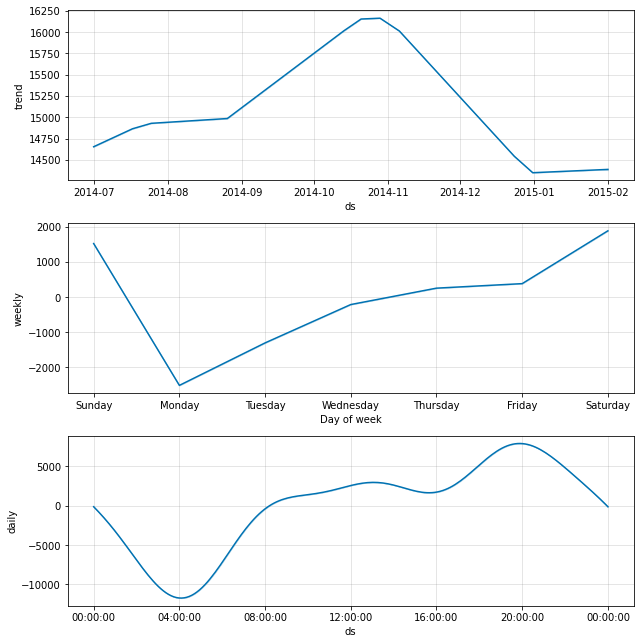

In [39]:
comp = model.plot_components(forecast)